In [1]:

import os
import zipfile
import re
import string
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
import joblib


nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)


True

In [2]:
# 1) Load / extract data
zip_file_name = '/content/Twitter Dataset.zip'  
expected_train = 'twitter_training.csv'
expected_test  = 'twitter_validation.csv'

if os.path.exists(zip_file_name) and not (os.path.exists(expected_train) and os.path.exists(expected_test)):
    with zipfile.ZipFile(zip_file_name, 'r') as z:
        z.extractall('.')
    print(f"Extracted {zip_file_name}")


if not os.path.exists(expected_train) or not os.path.exists(expected_test):
    raise FileNotFoundError(f"Expected '{expected_train}' and '{expected_test}' not found in working directory.")

# Many Twitter datasets have no header; adapt if needed
cols = ['id', 'game', 'label', 'tweet']
train_df = pd.read_csv(expected_train, header=None, names=cols, encoding='utf-8', low_memory=False)
test_df  = pd.read_csv(expected_test,  header=None, names=cols, encoding='utf-8', low_memory=False)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Extracted /content/Twitter Dataset.zip
Train shape: (74682, 4)
Test shape: (1000, 4)


In [3]:
# 2) Clean text function
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

CONTRACTION_MAP = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

def expand_contractions(text):
    # replace using word boundaries for safer substitution
    for c, expanded in CONTRACTION_MAP.items():
        pattern = re.compile(re.escape(c), flags=re.IGNORECASE)
        text = pattern.sub(expanded, text)
    return text

def clean_text(text):
    text = str(text).lower()
    text = expand_contractions(text)
    # remove urls and handles
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    # keep hashtags as words (drop '#')
    text = re.sub(r'#([A-Za-z0-9_]+)', r'\1', text)
    # remove punctuation (but keep internal apostrophes already expanded)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = [wnl.lemmatize(w) for w in text.split() if (w not in stop_words and len(w) > 1)]
    return " ".join(words)

# apply cleaning
train_df['clean_text'] = train_df['tweet'].astype(str).apply(clean_text)
test_df['clean_text']  = test_df['tweet'].astype(str).apply(clean_text)

In [4]:
# 3) Encode labels
# Moved LabelEncoder instantiation to before its first use
le = LabelEncoder()

# --- INSERT THIS BLOCK AFTER CLEANING, BEFORE SPLITTING ---

# Check initial size
initial_len = len(train_df)

# Drop duplicates based on the processed text
# We keep the first occurrence and drop the rest
train_df = train_df.drop_duplicates(subset=['clean_text'])

# Check new size
final_len = len(train_df)
print(f"Dropped {initial_len - final_len} duplicate rows.")

# Now define X and y from the CLEANED dataframe
X = train_df['clean_text']
y = le.fit_transform(train_df['label'].astype(str))  # numeric labels



# checking
print(train_df[['tweet','clean_text']].head(3).to_string(index=False))


print("Classes:", le.classes_)

X = train_df['clean_text']

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train rows:", len(X_train), "Val rows:", len(X_val))

Dropped 13814 duplicate rows.
                                                tweet                   clean_text
im getting on borderlands and i will murder you all , im getting borderland murder
  I am coming to the borders and I will kill you all,           coming border kill
   im getting on borderlands and i will kill you all,   im getting borderland kill
Classes: ['Irrelevant' 'Negative' 'Neutral' 'Positive']
Train rows: 48694 Val rows: 12174


In [5]:
# 4) Pipeline + GridSearch
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        analyzer='word',
        ngram_range=(1,2),     # try (1,3) if you have memory
        max_features=20000,
        min_df=5,
        sublinear_tf=True
    )),
    ('clf', LogisticRegression(
        solver='saga',         # fast with large features; supports multinomial
        multi_class='multinomial',
        max_iter=2000,
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    'tfidf__ngram_range': [(1,1),(1,2)],   # expand if memory allows
    'tfidf__max_features': [5000, 15000, 20000],
    'clf__C': [0.1, 1.0, 5.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV f1_weighted:", grid.best_score_)

best_model = grid.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best params: {'clf__C': 5.0, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Best CV f1_weighted: 0.7779541845172903


In [6]:
# 5) Validation evaluation
y_val_pred = best_model.predict(X_val)
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
rec = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)

print("Validation Metrics:")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall :", rec)
print("F1-score :", f1)
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion matrix:\n", cm)

Validation Metrics:
Accuracy : 0.8289797930014786
Precision: 0.8292808313090441
Recall : 0.8289797930014786
F1-score : 0.8284503883907479

Classification Report:

              precision    recall  f1-score   support

  Irrelevant       0.83      0.76      0.79      2154
    Negative       0.83      0.88      0.85      3742
     Neutral       0.85      0.81      0.83      3045
    Positive       0.81      0.83      0.82      3233

    accuracy                           0.83     12174
   macro avg       0.83      0.82      0.82     12174
weighted avg       0.83      0.83      0.83     12174

Confusion matrix:
 [[1634  222  109  189]
 [ 105 3307  139  191]
 [ 103  244 2469  229]
 [ 130  225  196 2682]]


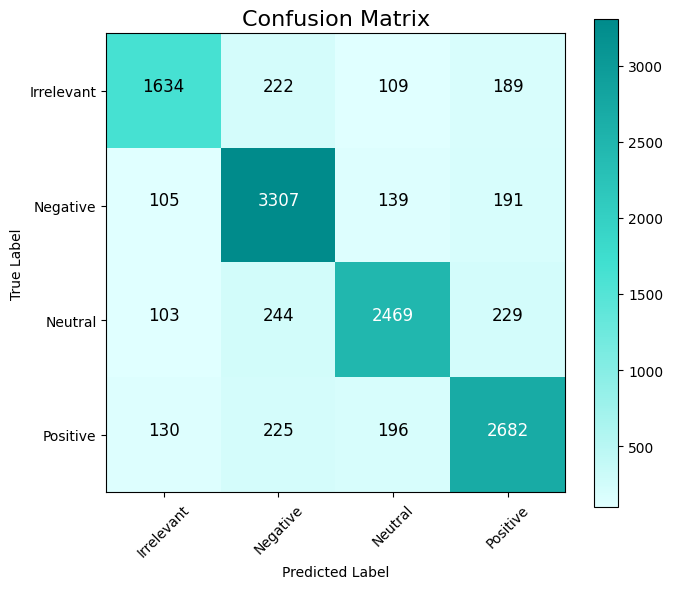

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
classes = le.classes_

plt.figure(figsize=(7, 6))

# Create turquoise colormap
from matplotlib.colors import LinearSegmentedColormap
turquoise_cmap = LinearSegmentedColormap.from_list("turquoise",
                                                   ["#e0ffff", "#40e0d0", "#008b8b"])

plt.imshow(cm, interpolation='nearest', cmap=turquoise_cmap)
plt.title("Confusion Matrix", fontsize=16)
plt.colorbar()

# Tick labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Display numbers in each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [8]:
# 6) Multiclass ROC AUC (weighted)
# Binarize labels for AUC
y_val_bin = label_binarize(y_val, classes=np.arange(len(le.classes_)))
y_val_proba = best_model.predict_proba(X_val)  # shape (n_samples, n_classes)

try:
    roc_auc_weighted = roc_auc_score(y_val_bin, y_val_proba, average='weighted', multi_class='ovr')
    print("Weighted multiclass ROC AUC (ovr):", roc_auc_weighted)
except Exception as e:
    print("ROC AUC calculation failed:", e)

Weighted multiclass ROC AUC (ovr): 0.9551780056962299


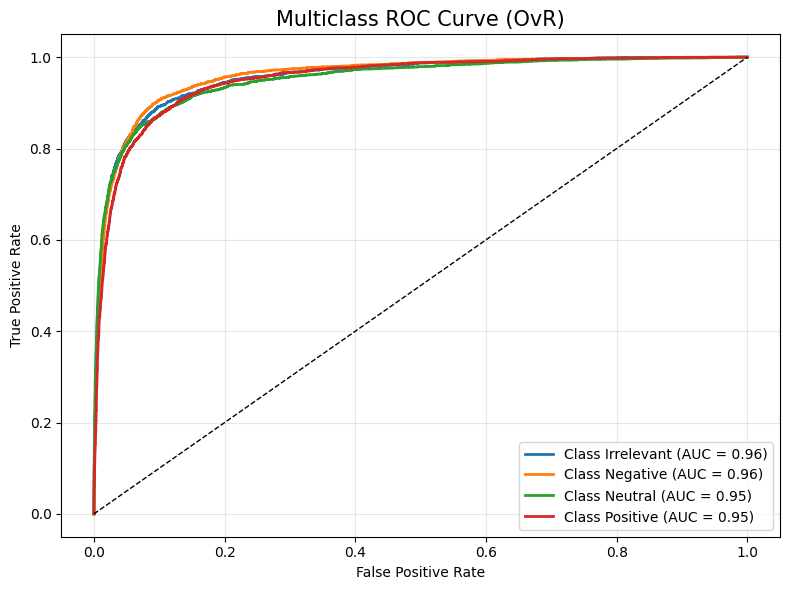

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels
y_val_bin = label_binarize(y_val, classes=np.arange(len(le.classes_)))
n_classes = y_val_bin.shape[1]

# Predict probabilities
y_val_proba = best_model.predict_proba(X_val)

# Use default matplotlib color cycle
plt.figure(figsize=(8, 6))

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label=f"Class {le.classes_[i]} (AUC = {roc_auc:.2f})",
             linewidth=2)

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.title("Multiclass ROC Curve (OvR)", fontsize=15)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# 7) Inspect top features per class
tfidf = best_model.named_steps['tfidf']
clf = best_model.named_steps['clf']
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_  # shape (n_classes, n_features)

n_top = 20
for i, cls in enumerate(le.classes_):
    top_idx = np.argsort(coefs[i])[-n_top:]
    top_feats = feature_names[top_idx]
    top_coefs = coefs[i][top_idx]
    print(f"\nTop features for class '{cls}':")
    for feat, c in zip(top_feats[::-1], top_coefs[::-1]):
        print(f"{feat:20s} : {c:.4f}")


Top features for class 'Irrelevant':
overwatch league     : 4.9128
montage              : 4.8582
tournament           : 4.5575
subscribe            : 4.4451
wow hearthstone      : 4.4149
poll                 : 4.4039
fridge               : 4.1976
mod                  : 4.1794
modi                 : 4.0983
zayn                 : 4.0516
jota                 : 4.0001
tweeting             : 3.9903
fat                  : 3.9618
shadow               : 3.9445
pussy                : 3.9178
studio               : 3.8383
299                  : 3.8363
voted                : 3.8264
facebook group       : 3.7845
wish best            : 3.7525

Top features for class 'Negative':
fix                  : 8.4356
glitch               : 5.0526
matchmaking          : 5.0231
lobby                : 4.7053
fifa                 : 4.6759
30eeddn              : 4.4498
ticket               : 4.3246
plague               : 4.3084
bullshit             : 4.2861
ruining              : 4.1830
powder               : 4.1

In [12]:
#  8) Refit final model on full training data
X_full = train_df['clean_text']
y_full = le.transform(train_df['label'].astype(str))
final_model = grid.best_estimator_
final_model.fit(X_full, y_full)
print("Final model trained on full training set.")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Final model trained on full training set.


In [13]:
# 9) Make predictions on test and save submission
if 'id' in test_df.columns:
    test_preds = final_model.predict(test_df['clean_text'])
    submission = pd.DataFrame({'id': test_df['id'], 'label': le.inverse_transform(test_preds)})
    submission.to_csv("submission.csv", index=False)
    print("Saved submission.csv")

Saved submission.csv


In [14]:
# 10) Save pipeline
joblib.dump(final_model, "sentiment_pipeline_lr.joblib")
print("Saved sentiment_pipeline_lr.joblib")

# convenience prediction
def predict_sentiment(text: str):
    cleaned = clean_text(text)
    pred = final_model.predict([cleaned])[0]
    return le.inverse_transform([pred])[0]

# Example
print("Example:", predict_sentiment("I really love this movie, it was fantastic!"))

Saved sentiment_pipeline_lr.joblib
Example: Positive


In [15]:
# Example
print("Example:", predict_sentiment("I really likes this movie!"))
# Example
print("Example:", predict_sentiment("I hate this, what the heck"))
# Example
print("Example:", predict_sentiment("I don't care!"))
# Example
print("Example:", predict_sentiment("Toy's shadow is on the wall"))

Example: Positive
Example: Negative
Example: Neutral
Example: Irrelevant


In [28]:
!pip install -q streamlit pyngrok joblib nltk


In [19]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.3 MB/s eta 0:00:00


In [21]:
from pyngrok import ngrok

ngrok.set_auth_token("36PTSi9eUTorHizEVIXKJffidjR_5RrepySv3jNdgpmKn7YNJ")


In [30]:
# --- Save model and label encoder (run after training) ---
import joblib, pickle
# final_model : your trained sklearn Pipeline (from your code)
# le : your fitted sklearn.preprocessing.LabelEncoder

joblib.dump(final_model, "sentiment_pipeline_lr.joblib")
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Saved: sentiment_pipeline_lr.joblib and label_encoder.pkl")


Saved: sentiment_pipeline_lr.joblib and label_encoder.pkl


In [31]:
#updating
%%writefile sentiment_app.py
import streamlit as st
import joblib
import pickle
import re
import string
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# -------------------------
# NLTK downloads (first-run)
# -------------------------
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# -------------------------
# Paths
# -------------------------
MODEL_PATH = "sentiment_pipeline_lr.joblib"
LE_PATH = "label_encoder.pkl"

st.set_page_config(page_title="Sentiment Analysis", layout="centered")
st.title("💬 Sentiment Analysis")

# -------------------------
# Load model (graceful)
# -------------------------
model = None
le = None

if os.path.exists(MODEL_PATH):
    try:
        model = joblib.load(MODEL_PATH)
        st.success("Loaded model.")
    except Exception as e:
        st.error(f"Failed to load model: {e}")
else:
    st.warning(f"Model file not found: {MODEL_PATH}. Please ensure file is in app directory.")

# Try to load label encoder from disk, or allow user upload
if os.path.exists(LE_PATH):
    try:
        with open(LE_PATH, "rb") as f:
            le = pickle.load(f)
        st.success("Loaded label encoder.")
    except Exception as e:
        st.error(f"Failed to load label encoder: {e}")
else:
    st.info("Label encoder not found. You can upload a `label_encoder.pkl` file here.")
    uploaded_le = st.file_uploader("Upload label_encoder.pkl", type=["pkl"])
    if uploaded_le:
        try:
            le = pickle.load(uploaded_le)
            st.success("Label encoder loaded from upload.")
        except Exception as e:
            st.error(f"Uploaded file could not be read as pickle: {e}")

# -------------------------
# Text cleaning (same logic as training)
# -------------------------
CONTRACTION_MAP = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

def expand_contractions(text):
    for c, expanded in CONTRACTION_MAP.items():
        pattern = re.compile(re.escape(c), flags=re.IGNORECASE)
        text = pattern.sub(expanded, text)
    return text

def clean_text(text):
    text = str(text).lower()
    text = expand_contractions(text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#([A-Za-z0-9_]+)', r'\1', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = [lemmatizer.lemmatize(w) for w in text.split() if (w not in stop_words and len(w) > 1)]
    return " ".join(words)

def predict_sentiment(text):
    if model is None:
        raise RuntimeError("Model not loaded.")
    cleaned = clean_text(text)
    pred = model.predict([cleaned])[0]
    # if label encoder present, inverse_transform numeric labels
    if le is not None:
        try:
            return le.inverse_transform([pred])[0]
        except Exception:
            # maybe model already returns string labels
            return pred
    else:
        return pred

# -------------------------
# UI
# -------------------------
st.markdown("Enter some text and click Predict. If the app can't find `label_encoder.pkl` it will let you upload it.")
user_input = st.text_area("Enter text for prediction:", height=150)

if st.button("Predict"):
    if user_input.strip() == "":
        st.warning("Please enter some text.")
    else:
        try:
            sentiment = predict_sentiment(user_input)
            st.success(f"Sentiment: **{sentiment}**")
        except Exception as e:
            st.error(f"Prediction failed: {e}")
            st.info("Ensure `sentiment_pipeline_lr.joblib` and `label_encoder.pkl` are present and compatible with the pipeline.")


Overwriting sentiment_app.py


In [32]:
# 3.1 Install
!pip install -q streamlit pyngrok joblib nltk scikit-learn


In [33]:
# 3.3 Confirm files exist in /content
!ls -l /content | sed -n '1,200p'


total 13712
-rw-r--r-- 1 root root      288 Dec  6 14:29 label_encoder.pkl
-rw------- 1 root root      274 Dec  6 14:05 nohup.out
drwxr-xr-x 1 root root     4096 Nov 20 14:30 sample_data
-rw-r--r-- 1 root root     3915 Dec  6 14:30 sentiment_app.py
-rw-r--r-- 1 root root  1419916 Dec  6 14:29 sentiment_pipeline_lr.joblib
-rw-r--r-- 1 root root    14215 Dec  6 13:53 submission.csv
-rw-r--r-- 1 root root  2090169 Dec  6 13:47 Twitter Dataset.zip
-rw-r--r-- 1 root root 10325088 Dec  6 13:48 twitter_training.csv
-rw-r--r-- 1 root root   164351 Dec  6 13:48 twitter_validation.csv


In [34]:
# 3.4 Start streamlit in background and capture logs
# Note: nohup keeps it running and writes output to /content/streamlit.log
!nohup streamlit run sentiment_app.py --server.port 8501 --server.address 0.0.0.0 &>/content/streamlit.log &


In [35]:
# 3.5 Start ngrok and print public URL (run in same Notebook)
from pyngrok import ngrok
ngrok.set_auth_token("36PTSi9eUTorHizEVIXKJffidjR_5RrepySv3jNdgpmKn7YNJ")   # <-- replace
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://ungrantable-brantlee-gibbed.ngrok-free.dev" -> "http://localhost:8501">

In [22]:
%%writefile sentiment_app.py
import streamlit as st
import joblib
import pickle
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ----------------------------------
# Load trained model + label encoder
# ----------------------------------
model = joblib.load("sentiment_pipeline_lr.joblib")

with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# ----------------------------------
# Load NLP dependencies
# ----------------------------------
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# ----------------------------------
# Actual clean_text function (your original)
# ----------------------------------
def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords + lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]

    return " ".join(words)


# ----------------------------------
# Prediction function
# ----------------------------------
def predict_sentiment(text):
    cleaned = clean_text(text)
    pred = model.predict([cleaned])[0]
    return le.inverse_transform([pred])[0]


# ----------------------------------
# Streamlit UI
# ----------------------------------
st.title("💬 Sentiment Analysis App")

user_input = st.text_area("Enter text for prediction:", height=150)

if st.button("Predict"):
    if user_input.strip() == "":
        st.warning("Please enter some text.")
    else:
        sentiment = predict_sentiment(user_input)
        st.success(f"Sentiment: {sentiment}")


Writing sentiment_app.py


In [26]:
!nohup streamlit run sentiment_app.py --server.port 8501 --server.address 0.0.0.0 &


nohup: appending output to 'nohup.out'


In [27]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://ungrantable-brantlee-gibbed.ngrok-free.dev" -> "http://localhost:8501">